In [12]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from google.colab import drive
import zipfile
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.utils import plot_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ekstrak file dataset.zip
zip_path = "/content/drive/MyDrive/splitted_dataset.zip"
extract_path = "/content/splitted_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path)

Extracted to: /content/


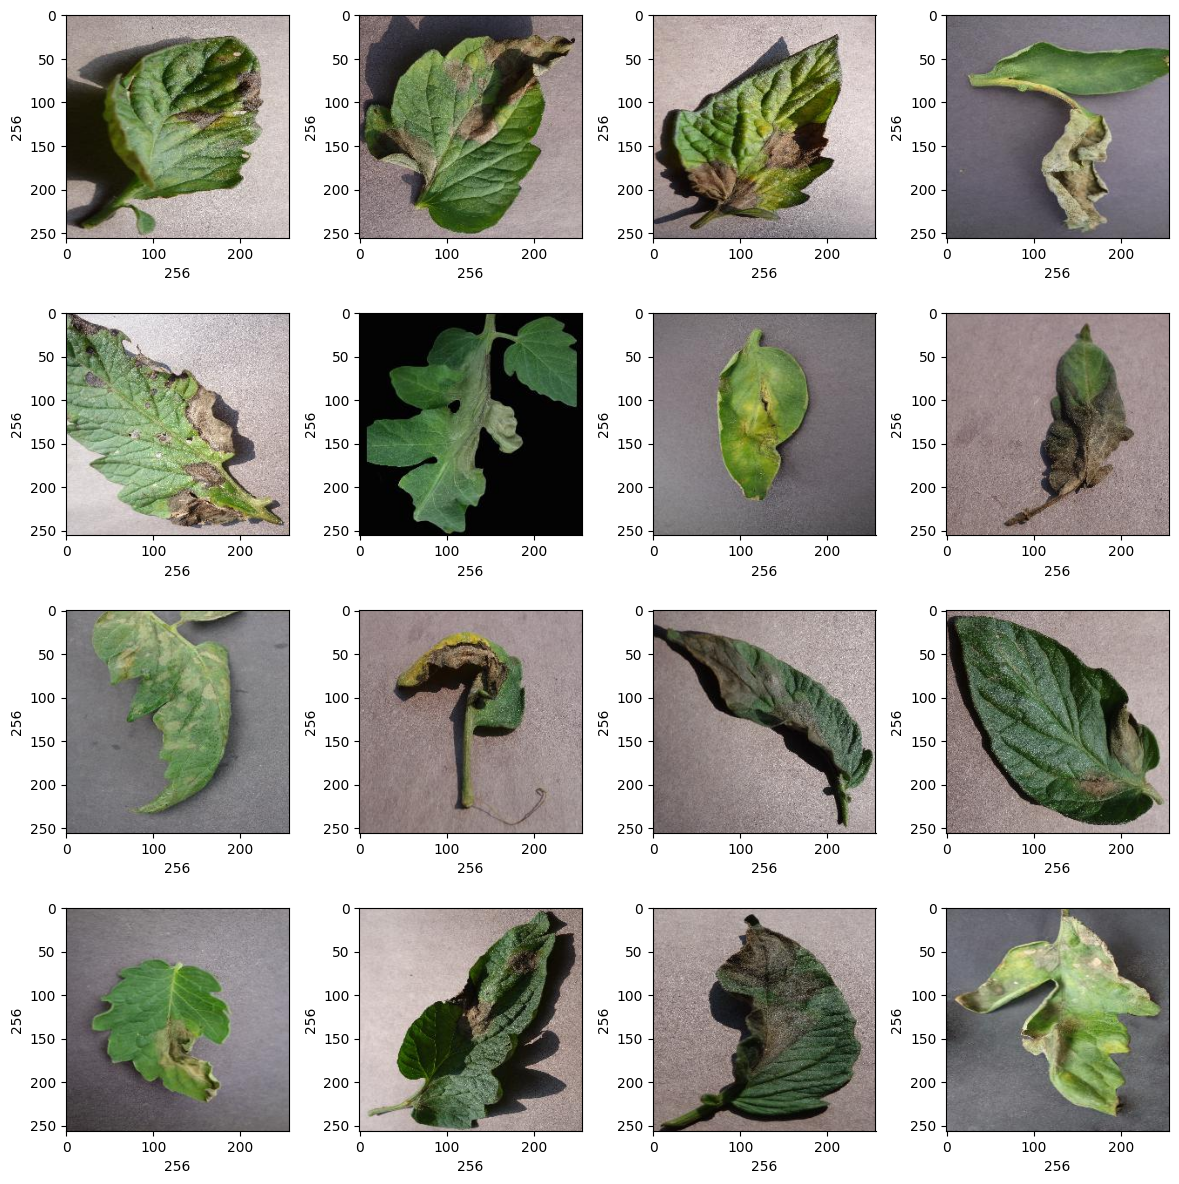

In [4]:
plt.figure(figsize = (12, 12))
dataset_path = "/content/train/Tomato__Late_Blight"

for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(dataset_path +'/'+ random.choice(sorted(os.listdir(dataset_path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

In [5]:
# Paths
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

In [6]:
def analyze_class_distribution(directory):
    """
    Analyze and visualize class distribution in the dataset
    """
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    # Visualize class distribution
    plt.figure(figsize=(15, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return class_counts

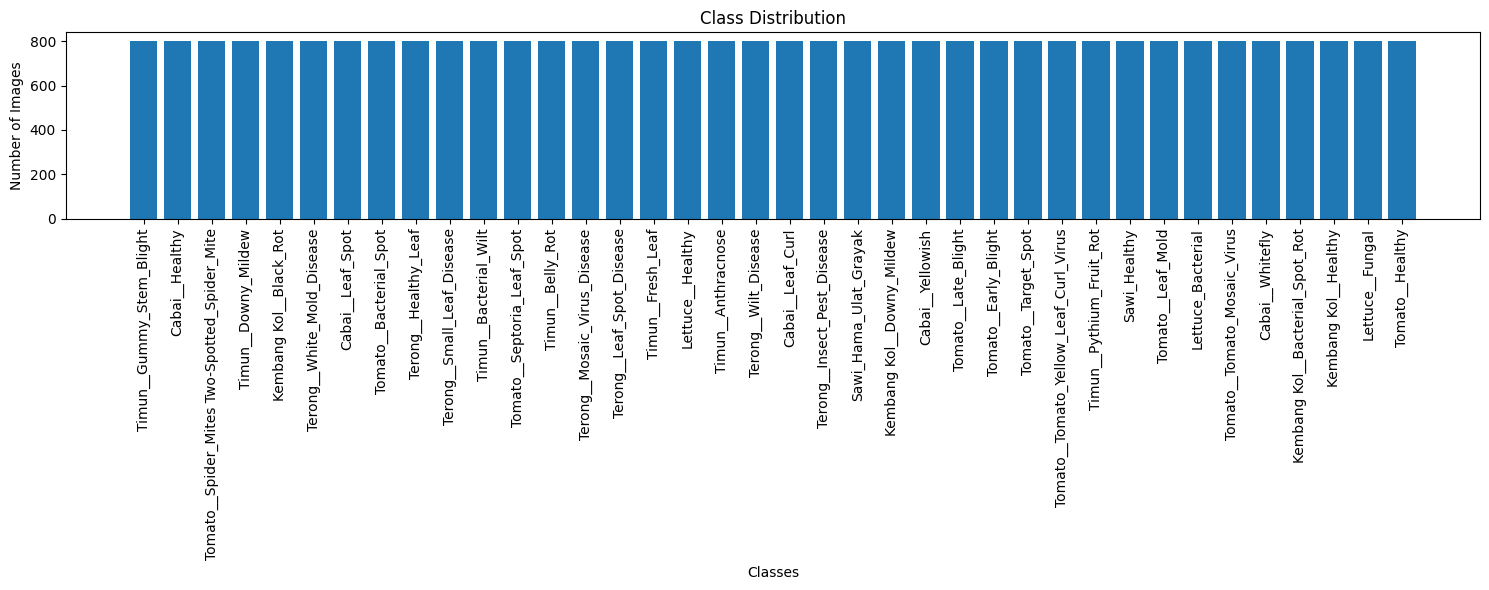

In [7]:
class_distribution = analyze_class_distribution(train_dir)

In [21]:
classes = ['Cabai__Healthy', 'Cabai__Leaf_Curl', 'Cabai__Leaf_Spot', 'Cabai__Whitefly', 'Cabai__Yellowish', 'Kembang Kol__Bacterial_Spot_Rot', 'Kembang Kol__Black_Rot', 'Kembang Kol__Downy_Mildew', 'Kembang Kol__Healthy', 'Lettuce_Bacterial', 'Lettuce__Fungal', 'Lettuce__Healthy', 'Sawi_Hama_Ulat_Grayak', 'Sawi_Healthy', 'Terong__Healthy_Leaf', 'Terong__Insect_Pest_Disease', 'Terong__Leaf_Spot_Disease', 'Terong__Mosaic_Virus_Disease', 'Terong__Small_Leaf_Disease', 'Terong__White_Mold_Disease', 'Terong__Wilt_Disease', 'Timun__Anthracnose', 'Timun__Bacterial_Wilt', 'Timun__Belly_Rot', 'Timun__Downy_Mildew', 'Timun__Fresh_Leaf', 'Timun__Gummy_Stem_Blight', 'Timun__Pythium_Fruit_Rot', 'Tomato__Bacterial_Spot', 'Tomato__Early_Blight', 'Tomato__Healthy', 'Tomato__Late_Blight', 'Tomato__Leaf_Mold', 'Tomato__Septoria_Leaf_Spot', 'Tomato__Spider_Mites Two-Spotted_Spider_Mite', 'Tomato__Target_Spot', 'Tomato__Tomato_Mosaic_Virus', 'Tomato__Tomato_Yellow_Leaf_Curl_Virus']

In [22]:
def create_datasets(path_dataset, image_size=(224, 224), batch_size=20):
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1./255)

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        seed=0,
        batch_size=batch_size,
        label_mode='categorical',
        image_size=image_size,
    ).map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)

    validation_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        seed=0,
        batch_size=batch_size,
        label_mode='categorical',
        image_size=image_size,
    ).map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)

    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        seed=0,
        batch_size=batch_size,
        label_mode='categorical',
        image_size=image_size,
    ).map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)

    return train_ds, validation_ds, test_ds

train_ds, validation_ds, test_ds = create_datasets('/content/')

Found 30400 files belonging to 38 classes.
Found 1543 files belonging to 38 classes.
Found 1562 files belonging to 38 classes.


In [23]:
base_model = keras.applications.MobileNetV2(
        include_top=False,
        input_shape=(224, 224, 3),
        weights="imagenet"
    )
base_model.trainable = False

model = Sequential([
    base_model,
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 5, 256)           │       2,949,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,479,526 (20.90 MB)

 Trainable params: 3,221,542 (12.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    )
file_path = "/content/vegecare_model_mobilenetv2.weights.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
    )

In [26]:
def calculate_class_weights(train_dataset):
    labels = []
    for _, y in train_dataset:
        labels.extend(np.argmax(y.numpy(), axis=1))

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    return dict(enumerate(class_weights))

class_weights = calculate_class_weights(train_ds)

In [27]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights
)

Epoch 1/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 162s 97ms/step - accuracy: 0.2431 - loss: 3.0518 - val_accuracy: 0.7634 - val_loss: 0.7712
Epoch 2/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 142s 93ms/step - accuracy: 0.6547 - loss: 1.1321 - val_accuracy: 0.8315 - val_loss: 0.5227
Epoch 3/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 139s 92ms/step - accuracy: 0.7646 - loss: 0.7496 - val_accuracy: 0.8425 - val_loss: 0.4786
Epoch 4/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 141s 93ms/step - accuracy: 0.8209 - loss: 0.5652 - val_accuracy: 0.8717 - val_loss: 0.4044
Epoch 5/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 141s 93ms/step - accuracy: 0.8638 - loss: 0.4287 - val_accuracy: 0.8872 - val_loss: 0.3737
Epoch 6/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 140s 92ms/step - accuracy: 0.8908 - loss: 0.3464 - val_accuracy: 0.8788 - val_loss: 0.4107
Epoch 7/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 146s 96ms/step - accuracy: 0.9036 - loss: 0.3012 - val_accuracy: 0.8918 - val_loss: 0.3552
Epoch 8/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 197s 93ms/step - accuracy: 

KeyboardInterrupt: 

In [28]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

fine_tune_lr = 1e-5
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    metrics=['accuracy']
)

# Continue training for fine-tuning
fine_tune_history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights
)

Epoch 1/20
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 172s 98ms/step - accuracy: 0.6937 - loss: 2.4944 - val_accuracy: 0.8730 - val_loss: 0.5929
Epoch 2/20
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 144s 95ms/step - accuracy: 0.8319 - loss: 0.6945 - val_accuracy: 0.8795 - val_loss: 0.5143
Epoch 3/20
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 202s 94ms/step - accuracy: 0.8748 - loss: 0.4634 - val_accuracy: 0.8859 - val_loss: 0.4425
Epoch 4/20
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 204s 96ms/step - accuracy: 0.9030 - loss: 0.3347 - val_accuracy: 0.8950 - val_loss: 0.3730
Epoch 5/20
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 201s 95ms/step - accuracy: 0.9215 - loss: 0.2709 - val_accuracy: 0.9151 - val_loss: 0.3488
Epoch 6/20
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 149s 98ms/step - accuracy: 0.9374 - loss: 0.2166 - val_accuracy: 0.9203 - val_loss: 0.3449
Epoch 7/20
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 144s 94ms/step - accuracy: 0.9434 - loss: 0.1834 - val_accuracy: 0.9196 - val_loss: 0.3314
Epoch 8/20
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 145s 95ms/step - accuracy: 

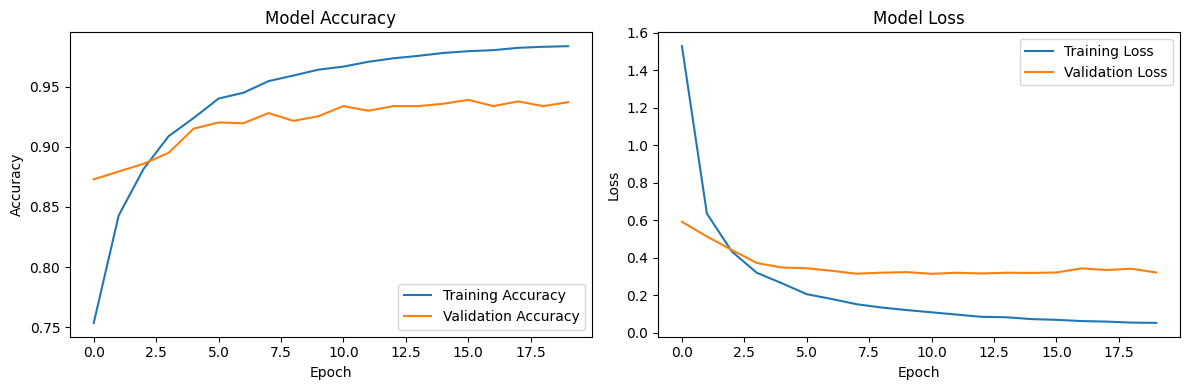

In [30]:
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call after training
plot_learning_curves(fine_tune_history)

In [31]:
MODEL_PATH = "/content/vegecare_model_efficientnetb3finetune.h5"
model.save(MODEL_PATH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

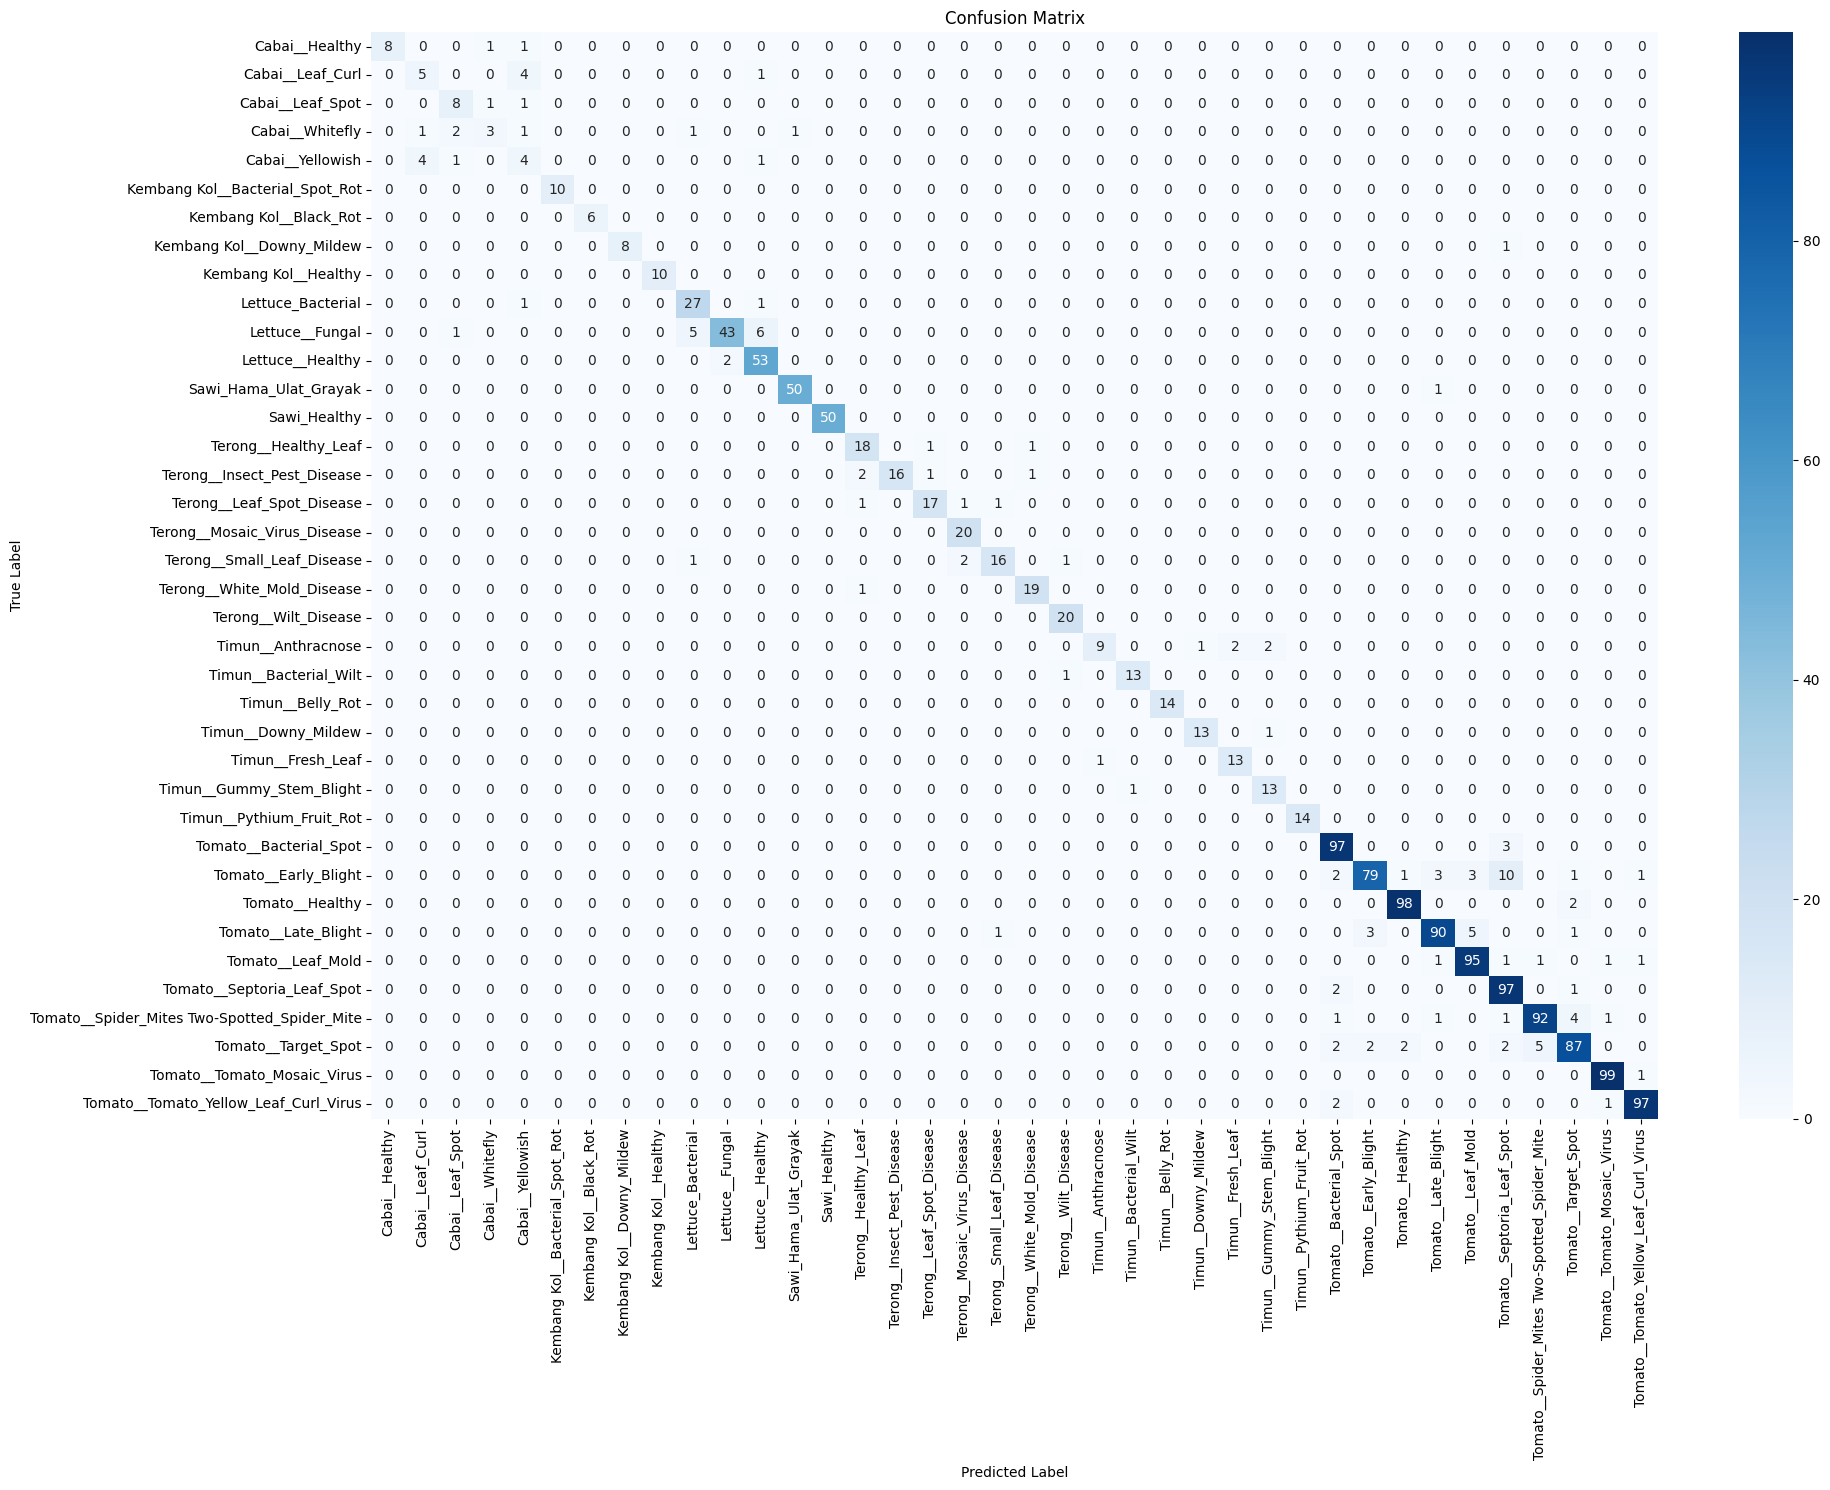


Per-Class Accuracy:
Cabai__Healthy:
  Total Samples: 10
  Correct Predictions: 8
  Accuracy: 80.00%
Cabai__Leaf_Curl:
  Total Samples: 10
  Correct Predictions: 5
  Accuracy: 50.00%
Cabai__Leaf_Spot:
  Total Samples: 10
  Correct Predictions: 8
  Accuracy: 80.00%
Cabai__Whitefly:
  Total Samples: 9
  Correct Predictions: 3
  Accuracy: 33.33%
Cabai__Yellowish:
  Total Samples: 10
  Correct Predictions: 4
  Accuracy: 40.00%
Kembang Kol__Bacterial_Spot_Rot:
  Total Samples: 10
  Correct Predictions: 10
  Accuracy: 100.00%
Kembang Kol__Black_Rot:
  Total Samples: 6
  Correct Predictions: 6
  Accuracy: 100.00%
Kembang Kol__Downy_Mildew:
  Total Samples: 9
  Correct Predictions: 8
  Accuracy: 88.89%
Kembang Kol__Healthy:
  Total Samples: 10
  Correct Predictions: 10
  Accuracy: 100.00%
Lettuce_Bacterial:
  Total Samples: 29
  Correct Predictions: 27
  Accuracy: 93.10%
Lettuce__Fungal:
  Total Samples: 55
  Correct Predictions: 43
  Accuracy: 78.18%
Lettuce__Healthy:
  Total Samples: 55
  Co

In [32]:
def evaluate_model_performance(model, test_ds, classes):
    # Collect true labels and predictions
    true_labels = []
    predictions = []

    # Iterate through test dataset to get true labels and predictions
    for images, labels in test_ds:
        # Get class indices from one-hot encoded labels
        true_batch_labels = np.argmax(labels.numpy(), axis=1)
        true_labels.extend(true_batch_labels)

        # Get model predictions
        batch_predictions = model.predict(images)
        predictions.extend(np.argmax(batch_predictions, axis=1))

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # 1. Detailed Classification Report
    print("Detailed Classification Report:")
    print(classification_report(true_labels, predictions, target_names=classes))

    # 2. Confusion Matrix Visualization
    plt.figure(figsize=(20,15))
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # 3. Per-class Accuracy
    per_class_accuracy = {}
    for i, class_name in enumerate(classes):
        class_total = np.sum(true_labels == i)
        class_correct = np.sum((true_labels == i) & (predictions == i))
        accuracy = class_correct / class_total if class_total > 0 else 0
        per_class_accuracy[class_name] = {
            'total_samples': class_total,
            'correct_predictions': class_correct,
            'accuracy': accuracy
        }

    # Print Per-class Accuracy
    print("\nPer-Class Accuracy:")
    for class_name, stats in per_class_accuracy.items():
        print(f"{class_name}:")
        print(f"  Total Samples: {stats['total_samples']}")
        print(f"  Correct Predictions: {stats['correct_predictions']}")
        print(f"  Accuracy: {stats['accuracy']:.2%}")

    return true_labels, predictions, per_class_accuracy

# Use the function after training
true_labels, predictions, per_class_accuracy = evaluate_model_performance(model, test_ds, classes)

In [33]:
def calculate_advanced_metrics(true_labels, predictions):
    # Macro average (treats all classes equally)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro'
    )

    # Weighted average (considers class imbalance)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='weighted'
    )

    print("\nAdvanced Metrics:")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Weighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate after getting predictions
calculate_advanced_metrics(true_labels, predictions)


Advanced Metrics:
Macro F1 Score: 0.8787
Weighted F1 Score: 0.9153
Macro Precision: 0.8874
Macro Recall: 0.8775
Weighted Precision: 0.9189
Weighted Recall: 0.9161
